Ideas:
* Look at EOFs for other output variables, like clouds, ET
* Different spatial patterns for different parameters

* Find method for determining the number of EOFs that are statistically significant, how many EOFs needed to reconstruct -- something to calculate this threshold, Chris Bretherton, Dennis??


Plotting distributions of deltas

# Set up workspace

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from scipy.stats import ttest_ind
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from eofs.xarray import Eof 

In [2]:
import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils')

In [3]:
from load_ensembles import *
import quick_map

# Load data

In [4]:
var='calculated_PRECT'
domain='atm'
ensemble='coupled'

In [5]:
end_spinup=60

## Load full ensemble data

In [103]:
ensemble_coupled_ET = load_coupled_ensemble(var='EFLX_LH_TOT', domain='lnd', printon=False)
#ensemble_coupled_ET = load_offline_ensemble(var='EFLX_LH_TOT', domain='lnd', printon=False)

/glade/u/home/czarakas/coupled_PPE/code/utils/load_ensembles.py:46: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(fpath)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [7]:
if ensemble=='coupled':
    ensemble_coupled = load_coupled_ensemble(var=var, domain=domain, printon=False)
elif ensemble=='offline':
    ensemble_coupled = load_offline_ensemble(var=var, domain=domain, printon=False)

/glade/u/home/czarakas/coupled_PPE/code/utils/load_ensembles.py:46: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(fpath)


In [8]:
if ensemble=='offline':
    if domain=='atm':
        basecase_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/offline_simulations/'+
                                 'OFFL0000_PI_v02/atm/proc/tseries/OFFL0000_PI_v02.cam.h0.timeseries.'+var+'.nc')
        ref_tseries=basecase_lnd[var][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')
    elif domain=='lnd':
        basecase_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/offline_simulations/'+
                                 'OFFL0000_PI_v02/lnd/proc/tseries/OFFL0000_PI_v02.clm2.h0.timeseries.'+var+'.nc')
        ref_tseries=basecase_lnd[var][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')
elif ensemble=='coupled':
    if domain=='atm':
        basecase_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/'+
                                 'COUP0000_PI_SOM/atm/proc/tseries/COUP0000_PI_SOM.cam.h0.timeseries.'+var+'.nc')
        ref_tseries=basecase_lnd[var][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')
    elif domain=='lnd':
        basecase_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/'+
                                 'COUP0000_PI_SOM/lnd/proc/tseries/COUP0000_PI_SOM.clm2.h0.timeseries.'+var+'.nc')
        ref_tseries=basecase_lnd[var][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')

In [9]:
from load_gridcell_areas import *

## Make a data array that stacks all the differences from the reference 
(i.e. dimension are [lat, lon, num_ensemble_simulations]

In [10]:
ds_grid = ensemble_coupled[0]

In [11]:
import make_multisimulation_dataset

In [12]:
var_array = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)

In [13]:
season='Annual'#'Annual','DJF,'MAM','JJA','SON'
for i in np.arange(0,np.size(keys)):
    print(i)
    if season=='Annual':
        this_ensemble_tseries=ensemble_coupled[i][var][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')
    else:
        seasonfilter=ensemble_coupled[i][var]['time.season']==season
        this_ensemble_tseries=ensemble_coupled[i][var][end_spinup*12:,:,:].where(seasonfilter).groupby('time.year').mean(dim='time')
    #t, p = ttest_ind(this_ensemble_tseries, ref_tseries, equal_var=False)
    diff = this_ensemble_tseries.mean(dim='year')-ref_tseries.mean(dim='year')#-100
    #diff = this_ensemble_tseries.mean(dim='year')*100/ref_tseries.mean(dim='year')-100
    
    var_array[:,:,i]=diff
   # var_array_pvals[:,:,i]=p

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [104]:
var_ET='EFLX_LH_TOT'
var_array_ET = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ensemble_coupled_ET[0], 
                                                                 var=var_ET, 
                                                                 keys=keys)
basecase_lnd_ET=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/offline_simulations/'+
                                 'OFFL0000_PI_v02/lnd/proc/tseries/OFFL0000_PI_v02.clm2.h0.timeseries.'+var_ET+'.nc')
ref_tseries_ET=basecase_lnd_ET[var_ET][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')
season='Annual'#'Annual','DJF,'MAM','JJA','SON'
for i in np.arange(0,np.size(keys)):
    print(i)
    if season=='Annual':
        this_ensemble_tseries=ensemble_coupled_ET[i][var_ET][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')
    else:
        seasonfilter=ensemble_coupled_ET[i][var_ET]['time.season']==season
        this_ensemble_tseries=ensemble_coupled_ET[i][var_ET][end_spinup*12:,:,:].where(seasonfilter).groupby('time.year').mean(dim='time')
    #t, p = ttest_ind(this_ensemble_tseries, ref_tseries, equal_var=False)
    diff = this_ensemble_tseries.mean(dim='year')-ref_tseries_ET.mean(dim='year')#-100
    #diff = this_ensemble_tseries.mean(dim='year')*100/ref_tseries.mean(dim='year')-100
    
    var_array_ET[:,:,i]=diff
   # var_array_pvals[:,:,i]=p

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


0


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


1


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


3


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


4


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


5


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


6


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


7


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


8


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


9


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


10


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


11


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


12


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


13


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


14


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


15


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


16


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


17


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


18


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


19


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


20


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


21


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


22


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


23


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


24


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


25


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


26


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


27


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


28


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


29


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


30


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


31


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


32


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


33


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


34


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


35


/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [15]:
descriptions = []
for key in var_array.ensemble_key.values:
    if np.nansum(crosswalk.Key_short==key)>0:
        descriptions.append(crosswalk.description[crosswalk.Key_short==key].values[0])
    else:
        print('Error')
     #   descriptions.append('0000')
    #print(key)#ensemble_coupled=load_coupled_ensemble(var=var)

### Get area weights

#### Calculate area weights

In [16]:
import load_gridcell_areas

In [17]:
# area dataArray
ds_to_analyze=var_array[:,:,0]
da_area = area_grid(ds_to_analyze.lat, ds_to_analyze.lon)
# total area
total_area = da_area.sum(['lat','lon'])
#  weighted by grid-cell area
areaweights = (da_area) / total_area

In [18]:
landweights=landweights.reindex_like(areaweights, tolerance=0.05, method='nearest')

In [19]:
landweights_tropical=subset_landweights(latmax=23, latmin=-23, lonmax=1000, lonmin=-1000)
landweights_tropical=landweights_tropical.reindex_like(areaweights, tolerance=0.05, method='nearest')

# EOF analysis of changes in mean temperature

### Do EOF

In [105]:
deltaT=(var_array-var_array.mean(dim='ensemble_key'))
deltaT_global=(deltaT*landweights).mean(dim=['lat','lon'])
deltaT_normalized=deltaT#-deltaT_global

In [106]:
ds_eofs = deltaT_normalized#[:,:,0:34]
ds_eofs=ds_eofs*86400*365*1000

In [107]:
from datetime import datetime, timedelta
num_ensembles=np.shape(ds_eofs)[2]
print(num_ensembles)
date2=datetime(2000,1,1)+timedelta(days=num_ensembles, minutes=0)
date2_str=date2.isoformat()[0:10]

36


In [108]:
# Rearrange all-model dataset for EOF
ds_eofs=ds_eofs.transpose()
ds_eofs=ds_eofs.rename({"ensemble_key": "time"})
ds_eofs['time']=np.arange('2000-01-01', date2_str, dtype='datetime64') #11
ds_eofs=ds_eofs-ds_eofs.mean(dim='time')

In [109]:
#solver = Eof(ds_eofs, weights=areaweights.transpose())
solver = Eof(ds_eofs, weights=landweights_tropical.transpose())
eofs = solver.eofs()
eofs = eofs.transpose()
pcs = solver.pcs()#pcscaling=2)

#### Reconstruct

In [31]:
reconstructed=solver.reconstructedField(1)
reconstructed_mode0=eofs[:,:,0]*pcs[:,0]/landweights

In [32]:
diff=reconstructed_mode0[:,:,1]-reconstructed[1,:,:]

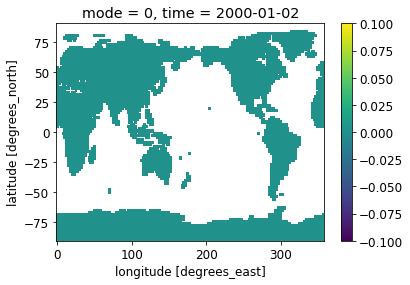

In [33]:
diff.plot()

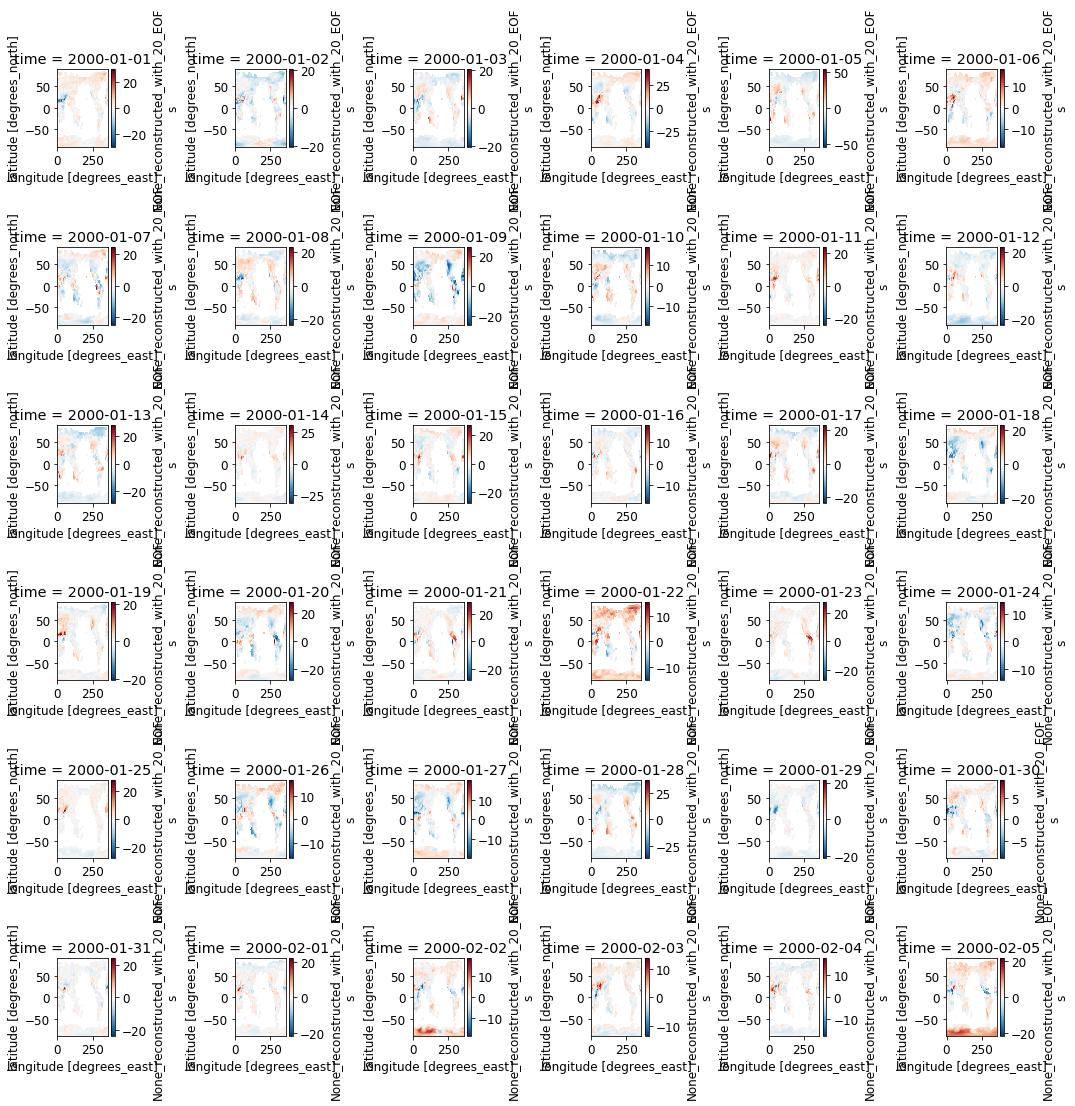

In [99]:
reconstructed=solver.reconstructedField(20)
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(15,15))
for i in np.arange(0,36):
    plt.subplot(6,6,i+1)
    reconstructed[i,:,:].transpose().plot()
plt.tight_layout()
plt.savefig('Global_Temperature_maps_'+'reconstructed'+'.png')

## Make figures

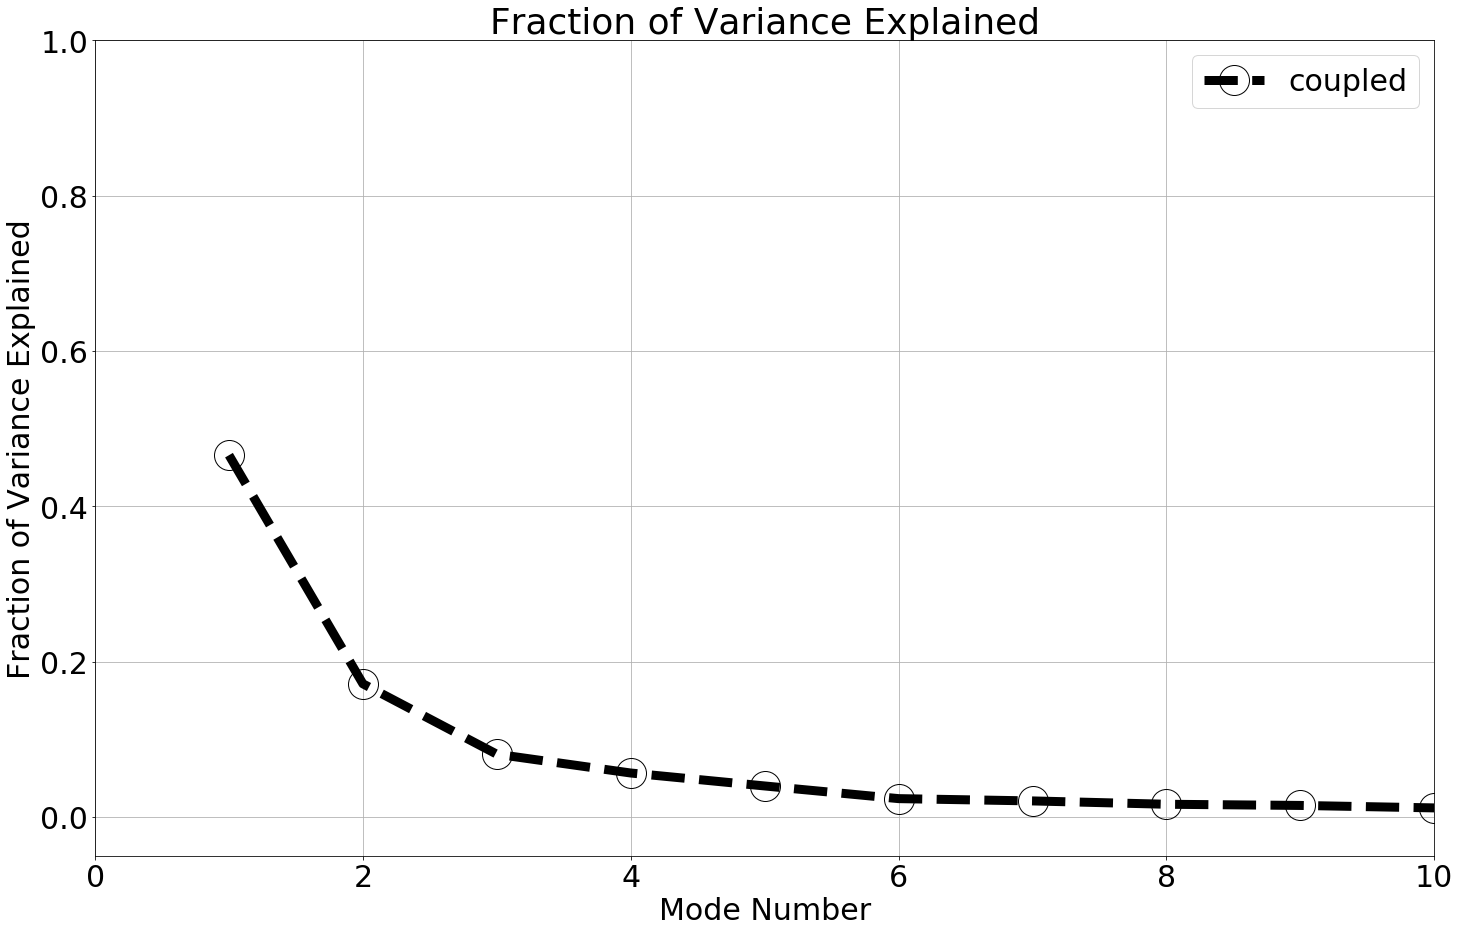

In [110]:
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(24,15))
plt.plot(np.arange(1,np.size(ds_eofs['time'])+1),solver.varianceFraction().values,
         'o--k', fillstyle='none',markersize=30,linewidth=9, label=ensemble)
solver.varianceFraction().values[0]+solver.varianceFraction().values[1]
plt.xlim([0,10])
plt.ylim([-0.05,1])
plt.title('Fraction of Variance Explained')
plt.xlabel('Mode Number')
plt.ylabel('Fraction of Variance Explained')
plt.grid()
plt.legend()
plt.savefig(var+'_frac_variance_explained.png')

In [111]:
for i in np.arange(0,4):
    print('EOF '+str(i+1))
    print(solver.varianceFraction().values[i])
#print(solver.varianceFraction().values[0:2])

EOF 1
0.46586774683223725
EOF 2
0.17147670412095964
EOF 3
0.08079326355766987
EOF 4
0.05660629006922305


/glade/u/home/czarakas/coupled_PPE/code/utils/quick_map.py:71: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  cbar.set_clim(clim)


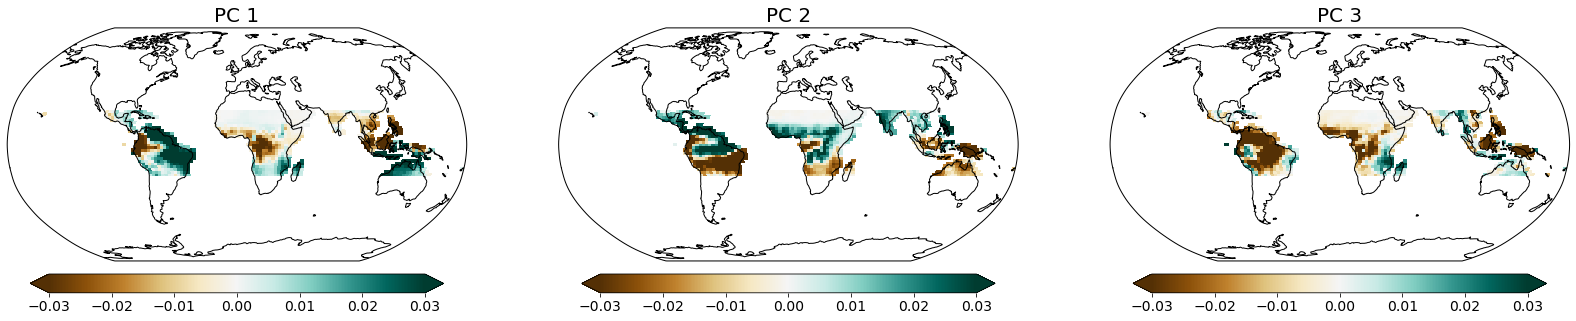

In [112]:
lats = eofs['lat'].values
lons = eofs['lon'].values
fig = plt.figure(figsize=(28, 12))
for i in range(0,3):
    quick_map.quick_map_subplot(((eofs[:,:,i])/landweights_tropical).values,lats,lons, nrow=1, ncol=3, ind=i,
                                clim=[-0.03,0.03], cmap=plt.cm.BrBG,
                                title='PC '+str(i+1))
plt.savefig(var+'_PCs.png')

In [113]:
import cartopy
plt.rcParams.update({'font.size': 40})
def quick_map_subplot_notglobal(mapdata_for_subplot, lat, lon, nrow=3, ncol=3, ind=1, title=None, cb_ttl=None,
              cmap=None, clim=None, filepath=None, sighatch=False,
              p=None, sigmask=None, markerstyle='x', markersize=1.0, norm=None):
    """ Creates map """
    fig = plt.figure(figsize=(30,15))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_extent([-180, 180, -22.5, 23], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.OCEAN, facecolor='white', zorder=1)
    ax.coastlines()#learn how to add resolution here??

    cyclic_data, cyclic_lons = add_cyclic_point(mapdata_for_subplot, coord=lon)

    if norm:
        cs = plt.pcolormesh(cyclic_lons, lat, cyclic_data,
                            transform=ccrs.PlateCarree())
    else:
        cs = plt.pcolormesh(cyclic_lons, lat, cyclic_data,
                            transform=ccrs.PlateCarree(), norm=norm)

    # Choose your colormap
    if cmap:
        plt.set_cmap(cmap)
    else:
        plt.set_cmap(plt.cm.viridis)

    ax.patch.set_alpha(1.0)
        
    plt.title(title, fontsize=20)

    if clim:
        plt.clim(clim)
        cs.set_clim(clim[0], clim[1])
        cs.set_clim(clim)
    
    cbar = plt.colorbar(ax=ax, orientation='horizontal',
                            extend='both', pad=.02, shrink=0.9, norm=norm)
    cbar.ax.tick_params()

    if clim:
        cbar.set_clim(clim)

    if cb_ttl:
        cbar.set_label(cb_ttl)
    
    plt.tight_layout()
    plt.savefig('Tropics_Precip_Map.png')

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.


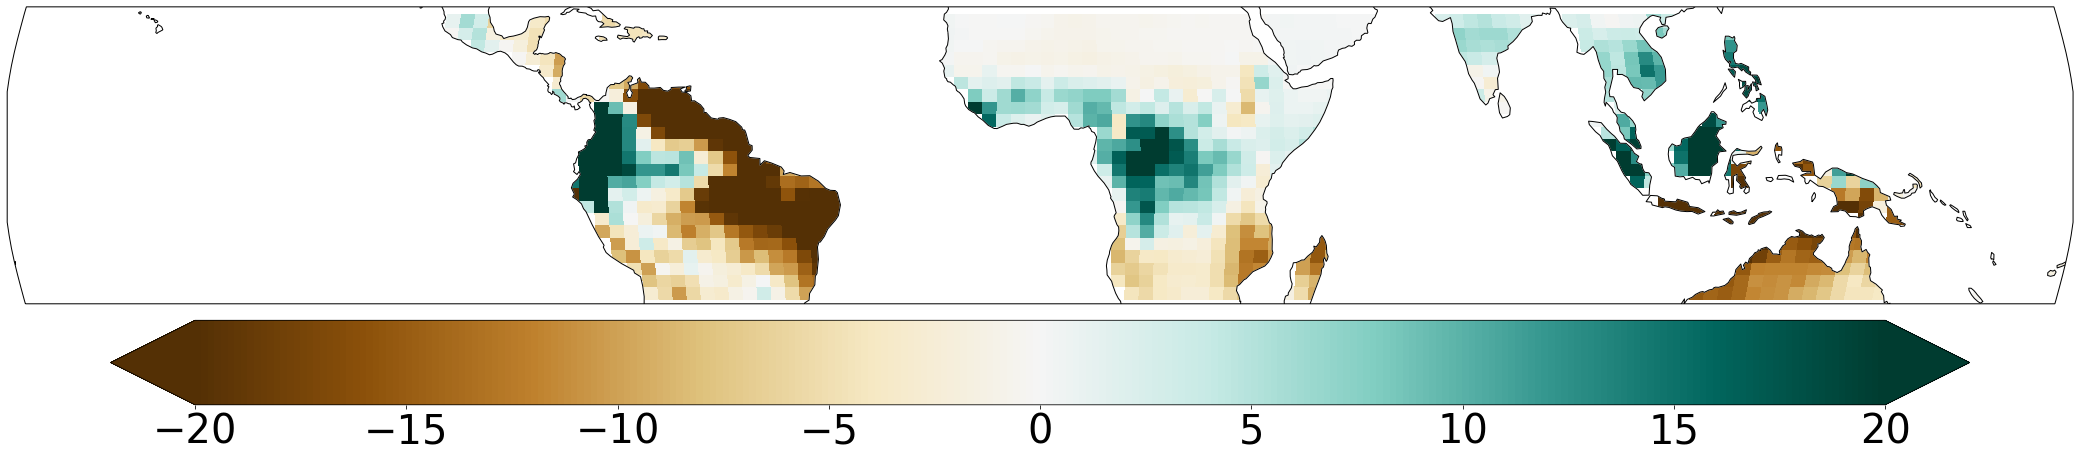

In [114]:
mapdata=-eofs[:,:,0]*500/landweights_tropical[35:60,:]#.plot()#*warming_factorPC0_1degreeglobal
quick_map_subplot_notglobal(mapdata, mapdata.lat, mapdata.lon, #nrow=1, ncol=1, 
                            clim=[-20,20],
                           cmap=plt.cm.BrBG)

In [152]:
data_range=(var_array.quantile(0.95,dim='ensemble_key')-
            var_array.quantile(0.05,dim='ensemble_key'))
mapdata=data_range.where(landweights>0)#*86400*365*1000

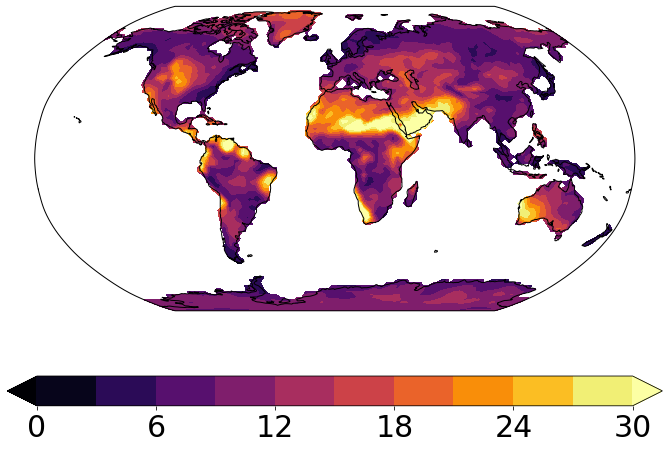

In [158]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

plt.contourf(cyclic_lons, mapdata.lat, #contourf
                   cyclic_data, 
                   cmap=plt.cm.get_cmap("inferno"), levels=np.arange(0,33,3), #levels=np.arange(-100,100),
                   transform=ccrs.PlateCarree(), extend='both')
plt.colorbar(extend='both', orientation='horizontal')#,# ticks=np.arange(-0.03,0.035,0.005))
plt.tight_layout()
plt.savefig('Annual_mm'+ensemble+'.png')

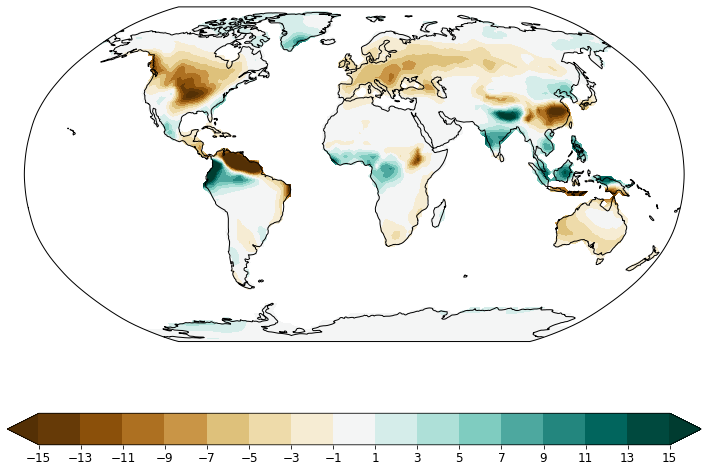

In [49]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

plt.contourf(cyclic_lons, mapdata.lat, #contourf
                   cyclic_data, 
                   cmap=plt.cm.get_cmap("BrBG"), levels=np.arange(-15,16,2), #levels=np.arange(-100,100),
                   transform=ccrs.PlateCarree(), extend='both')
plt.colorbar(extend='both', orientation='horizontal', ticks=np.arange(-15,16,2))
plt.tight_layout()
plt.savefig('EOF2_TSKIN_'+ensemble+'.png')

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

plt.pcolormesh(cyclic_lons, mapdata.lat, #contourf
                   cyclic_data, clim=[-2, 2], vmin=-2, vmax=2,
                   cmap=plt.cm.get_cmap("RdBu_r"), #levels=np.arange(-2.6,2.7,0.4), #levels=np.arange(-100,100),
                   transform=ccrs.PlateCarree(), )#, extend='both')
plt.colorbar(extend='both', orientation='horizontal')
plt.tight_layout()
plt.savefig('EOF2_CLDTOT.png')

# In EOF space 

In [92]:
plt.rcParams.update({'font.size': 14})

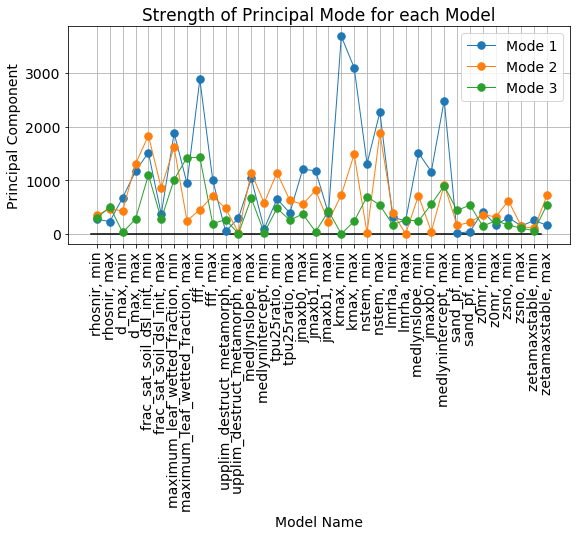

In [93]:
labels=descriptions#var_array.ensemble_key.values
fig = plt.figure(figsize=(9, 4))
plt.plot([0.5,np.size(labels)-0.5],[0,0],'-k')
for i in range(0,3):
    pcs_annual = np.abs(pcs[:,i])
    plt.plot(np.arange(1,np.size(pcs_annual['time'])+1),
             pcs_annual,label='Mode '+str(i+1),linewidth=1,marker='.',markersize=15)
    plt.xlabel('Model Name')
    plt.ylabel('Principal Component')
    plt.title('Strength of Principal Mode for each Model')
plt.legend()
#plt.xlim([0.5,np.size(labels)-0.5])
plt.xticks(np.arange(1,np.size(labels)+0.5,1),labels=labels, rotation=90)
plt.grid()
plt.savefig(var+'_strength_principal_mode_per_sim.png')

# Bar chart

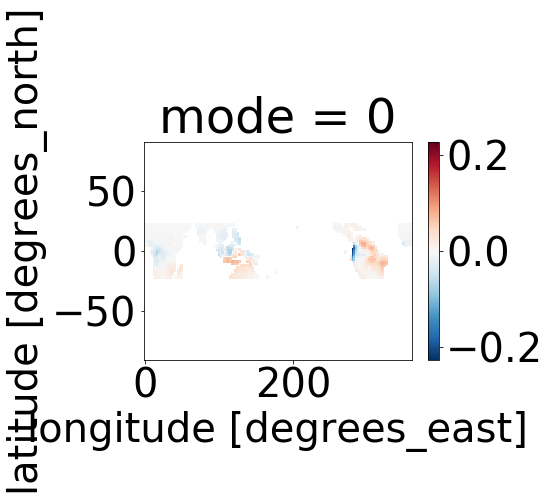

In [115]:
(eofs[:,:,0]/landweights_tropical).plot()

In [116]:
crosswalk['PCmode1']=np.nan
pc0=-pcs[:,0]/500

for i, desc in enumerate(var_array.ensemble_key.values):
    crosswalk['PCmode1'][i+1]=pc0[i]

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [117]:
params=['frac_sat_soil_dsl_init','d_max', 'fff','sand_pf',
        'upplim_destruct_metamorph', 'z0mr', 'zetamaxstable', 'zsno',
        'medlynintercept','kmax','medlynslope',
        'jmaxb0', 'jmaxb1', 'tpu25ratio',
        'rhosnir',
        'lmrha',
        'nstem','maximum_leaf_wetted_fraction']
param_colors=['blue','blue', 'blue','blue',
        'purple', 'purple', 'purple', 'purple',
        'forestgreen', 'forestgreen', 'forestgreen',
        'lightseagreen', 'lightseagreen','lightseagreen',
              'goldenrod',
              'lightgreen',
        'orange','orange']

In [118]:
tropical_ET_change=(var_array_ET*landweights_tropical).mean(dim=['lat','lon'])

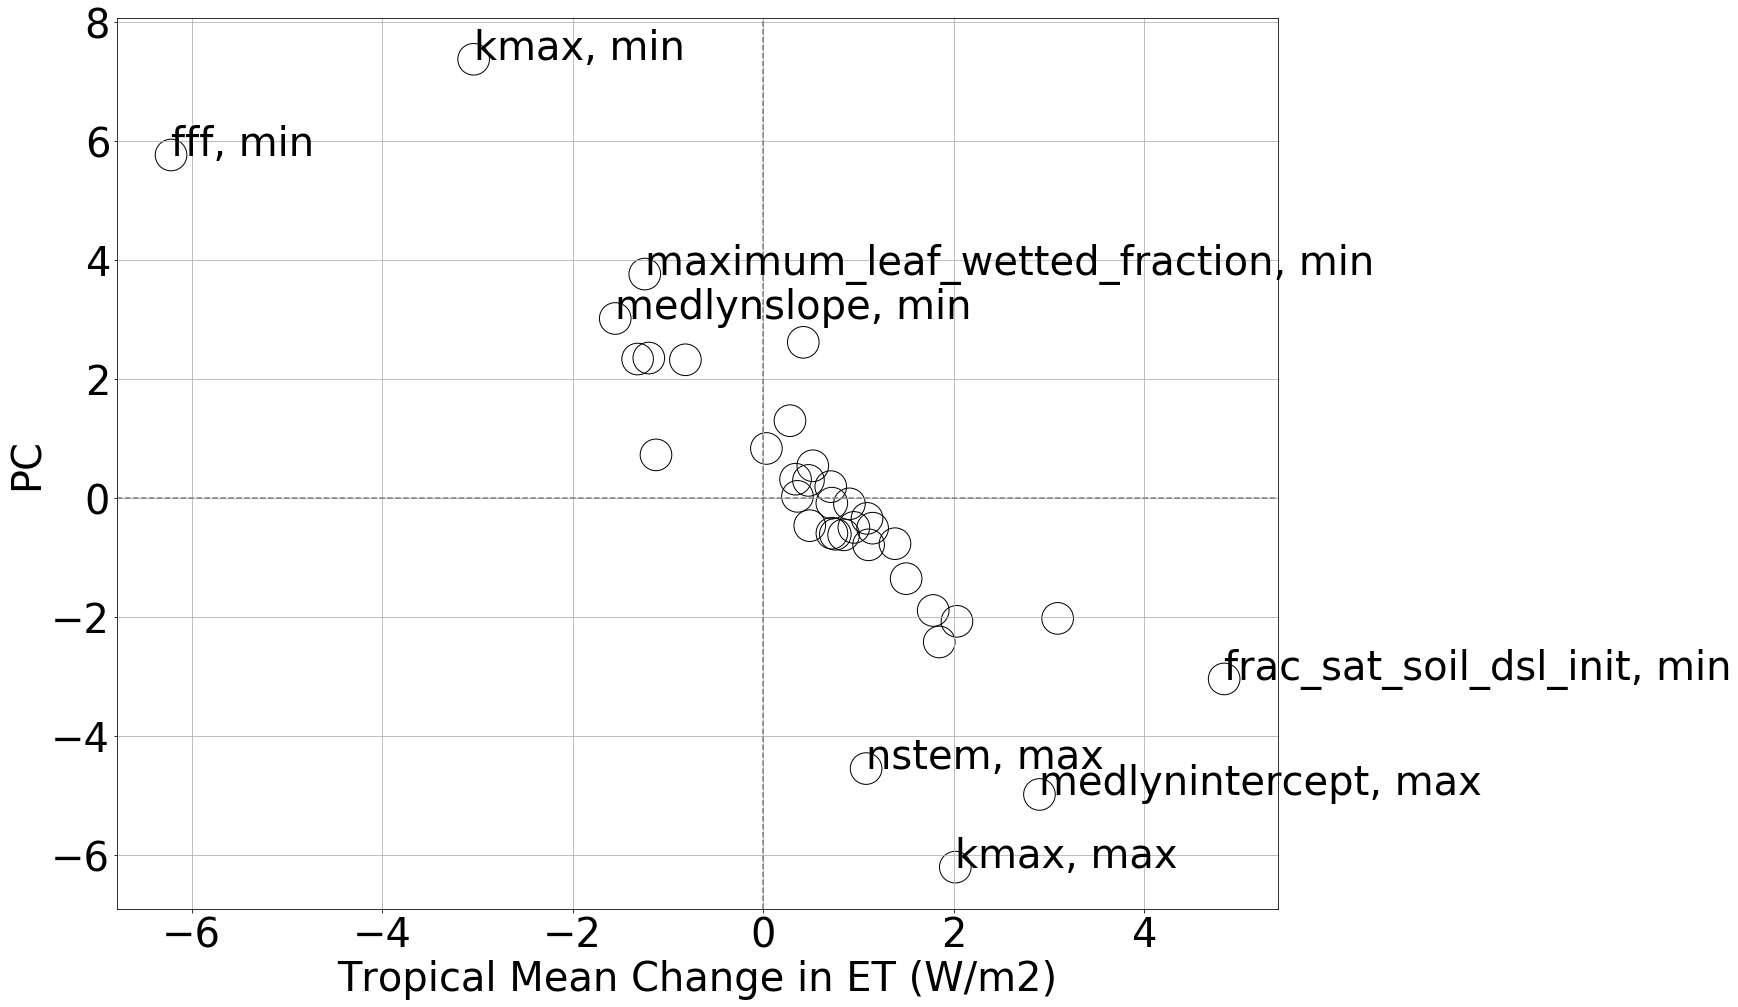

In [152]:
plt.figure(figsize=(25,15))
plt.rcParams.update({'font.size': 40})
x=tropical_ET_change.values
y=crosswalk['PCmode1'].values

plt.axhline(y=0,linestyle='--',color='gray')
plt.axvline(x=0,linestyle='--',color='gray')
plt.scatter(x,y ,s=1000,facecolor='none',
           edgecolor='k')
for i,desc in enumerate(crosswalk.description.values):
    if np.abs(y[i])>3:
        plt.annotate(desc, (x[i],crosswalk['PCmode1'].values[i]))
plt.xlabel('Tropical Mean Change in ET (W/m2)')
plt.ylabel('PC')
plt.tight_layout()
plt.grid()
plt.savefig('ScatterPlot_PCs')

In [145]:
crosswalk.description.values[19]

'kmax, min'

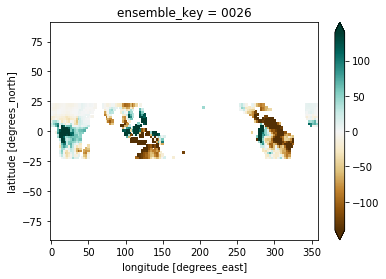

In [148]:
plt.rcParams.update({'font.size': 10})
(var_array[:,:,19].where(landweights_tropical>0)*86400*365*1000).plot(cmap=plt.cm.BrBG,
                                                                    vmin=-20*7, vmax=20*7)

(-1, 18)

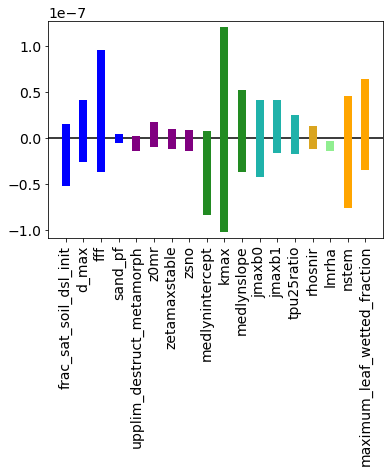

In [81]:
plt.rcParams.update({'font.size': 14})
plt.plot([-1,np.size(params)],[0,0],'-k')
for i, param in enumerate(params):
    minval=crosswalk['PCmode1'].values[crosswalk.description==param+', min']
    maxval=crosswalk['PCmode1'].values[crosswalk.description==param+', max']
    plt.plot([i,i], [minval,maxval],'.-', linewidth=8, color=param_colors[i])

plt.xticks(np.arange(0, i+1), params, rotation='vertical')
plt.xlim([-1,np.size(params)])

In [136]:
markerstyles=['o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'o',
             'o',
             'o',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v']

In [137]:
fillstyles=['none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'full',
             'none',
             'none',
             'full',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
            'none',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
           'none']

In [138]:
colors=['tab:blue',
             'tab:blue',
             'tab:orange',
             'tab:orange',
             'tab:green',
             'tab:green',
             'tab:red',
             'tab:red',
             'tab:purple',
             'tab:purple',
             'tab:brown',
             'tab:brown',
             'tab:pink', #WRONG
             'tab:olive', #WRONG
             'tab:cyan',
              'tab:cyan',
        'tab:gray',
            'tab:blue',
             'tab:blue',
             'tab:orange',
             'tab:orange',
             'tab:green',
             'tab:green',
             'tab:red',
             'tab:red',
             'tab:pink',
             'tab:gray',
             'tab:olive',
             'tab:pink',
             'tab:pink',
             'tab:cyan',
              'tab:cyan',
       'tab:gray',
       'tab:gray',
       'tab:olive',
        'tab:olive']

# Compare leading PC with global mean warming

In [318]:
warming_factorPC0_1degreeglobal=1/(eofs[:,:,0]*landweights).mean(dim=['lat','lon'])
(warming_factorPC0_1degreeglobal*(eofs[:,:,0]*landweights).mean(dim=['lat','lon']))

<xarray.DataArray ()>
array(1.)
Coordinates:
    mode     int64 0

In [319]:
global_mean_deltaT=[]
for m, modelname in enumerate(labels):
    deltaT_global=(deltaT_normalized[:,:,m]*landweights).mean(dim=['lat','lon']).values
    global_mean_deltaT.append(deltaT_global)

In [122]:
1/warming_factorPC0_1degreeglobal.values

-0.015519439977327153

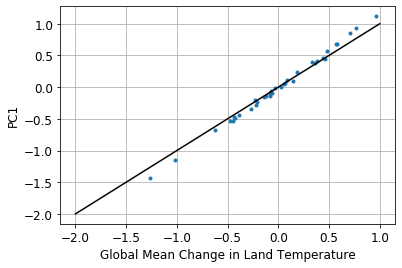

In [127]:
plt.plot(np.array(global_mean_deltaT),
         pcs[:,0].values/(-warming_factorPC0_1degreeglobal.values**2),'.')
plt.grid()
plt.xlabel('Global Mean Change in Land Temperature')
plt.ylabel('PC1')
plt.plot([-2,1],[-2,1],'-k')

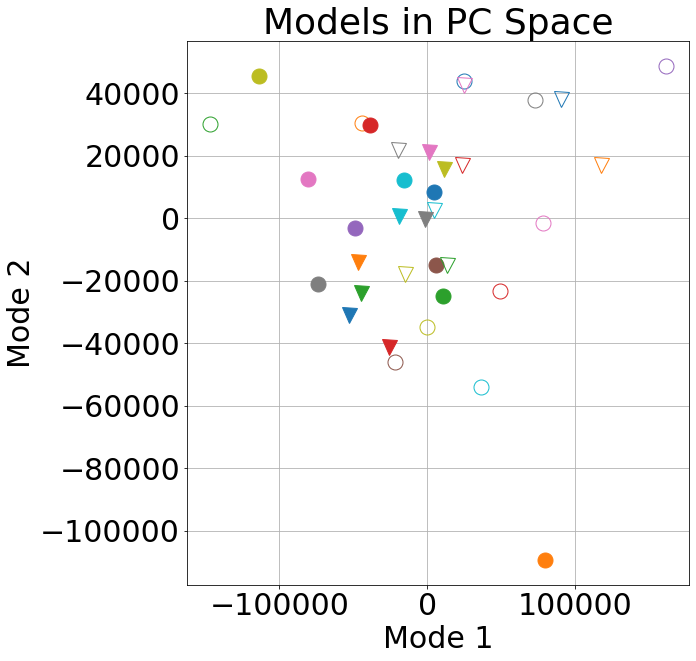

In [48]:
fig = plt.figure(figsize=(9, 10))
#plt.plot([-500,170],[0,0],'-k')
#plt.plot([0,0],[-175,150],'-k')
pc1 = (pcs[:,0].values)
pc2 = (pcs[:,1].values)
for m, modelname in enumerate(labels):
    if m%2==0:
        fillstyle='none'
    else:
        fillstyle='full'
    plt.plot(-pc1[m], pc2[m],markerstyles[m],color=colors[m],fillstyle=fillstyles[m],
             linewidth=0,markersize=15, label=modelname)
    #plt.plot(-pc1[m], pc2[m],markerstyles[m],'.,fillstyle=fillstyles[m],
    #         linewidth=0,markersize=15, label=modelname)
    #plt.annotate(modelname, [-pc1[m]+0.0002, pc2[m]-0.0001])
plt.xlabel('Mode 1')
plt.ylabel('Mode 2')
plt.title('Models in PC Space')
#plt.legend(fontsize=8, ncol=3)
#plt.xlim([-0.009,0.007])
#plt.ylim([-0.009,0.007])
#plt.ylim([-20,70])
plt.grid()
plt.savefig(var+'_PC1vsPC2_projection.png')

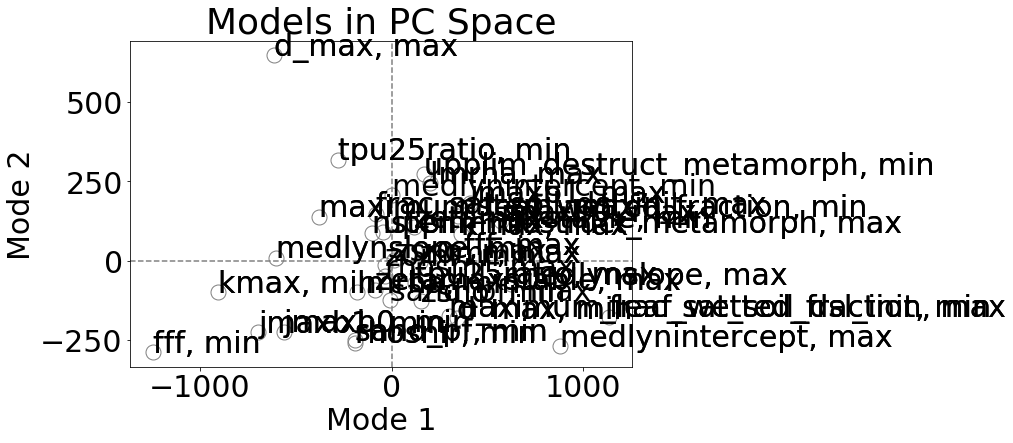

In [49]:
fig = plt.figure(figsize=(9, 6))
#plt.plot([-500,170],[0,0],'-k')
#plt.plot([0,0],[-175,150],'-k')
pc1 = pcs[:,0].values
pc2 = pcs[:,1].values
for m, modelname in enumerate(labels):
    if modelname=='CESM2':
        plt.plot(pc1[m], pc2[m],'.k',linewidth=0,markersize=15, label=modelname)
    else:
        plt.plot(pc1[m]/warming_factorPC0_1degreeglobal, 
                 pc2[m]/warming_factorPC1_1degreeglobal,
                 marker='o',fillstyle='none',color='gray',linewidth=0,markersize=15, label=modelname)

    if np.abs(pc1[m]/warming_factorPC0_1degreeglobal)>40:#0.75:
        plt.annotate(modelname, [pc1[m]/warming_factorPC0_1degreeglobal, 
                 pc2[m]/warming_factorPC1_1degreeglobal,])
    if np.abs(pc2[m]/warming_factorPC1_1degreeglobal)>0.1:#0.005:
        plt.annotate(modelname, [pc1[m]/warming_factorPC0_1degreeglobal, 
                pc2[m]/warming_factorPC1_1degreeglobal,])

plt.xlabel('Mode 1')
plt.ylabel('Mode 2')
plt.title('Models in PC Space')
#plt.legend(fontsize=12)
#plt.xlim([-110,150])
plt.axhline(y=0,linestyle='--',color='gray')
plt.axvline(x=0,linestyle='--',color='gray')
#plt.ylim([-0.1,0.1])
plt.savefig(var+'_PC1vsPC2_projection.png')

In [70]:
crosswalk['PCmode1']=np.nan
pc1=-pcs[:,0]/500

In [71]:
for i, desc in enumerate(var_array.ensemble_key.values):
    crosswalk['PCmode1'][i+1]=pc1[i]

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [72]:
params=['frac_sat_soil_dsl_init','d_max', 'fff','sand_pf',
        'upplim_destruct_metamorph', 'z0mr', 'zetamaxstable', 'zsno',
        'medlynintercept','kmax','medlynslope',
        'jmaxb0', 'jmaxb1', 'tpu25ratio',
        'rhosnir',
        'lmrha',
        'nstem','maximum_leaf_wetted_fraction']
param_colors=['blue','blue', 'blue','blue',
        'purple', 'purple', 'purple', 'purple',
        'forestgreen', 'forestgreen', 'forestgreen',
        'lightseagreen', 'lightseagreen','lightseagreen',
              'goldenrod',
              'lightgreen',
        'orange','orange']

(-1, 18)

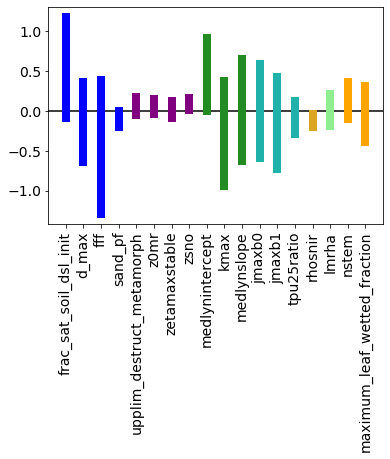

In [73]:
plt.rcParams.update({'font.size': 14})
plt.plot([-1,np.size(params)],[0,0],'-k')
for i, param in enumerate(params):
    minval=crosswalk['PCmode1'].values[crosswalk.description==param+', min']
    maxval=crosswalk['PCmode1'].values[crosswalk.description==param+', max']
    plt.plot([i,i], [minval,maxval],'.-', linewidth=8, color=param_colors[i])

plt.xticks(np.arange(0, i+1), params, rotation='vertical')
plt.xlim([-1,np.size(params)])

In [74]:
crosswalk

,key_CLM5PPE,param,minmax,include,parameter domain,parameter category,parameter description,key_coupledPPE,key_landonlyPPE,notes,Key_short,description,PCmode1
1,OAAT0013,rhosnir,min,yes,Vegetation,Plant optical properties,Stem reflectance: near-IR,COUP0001,OFFL0001,NaN,0001,"rhosnir, min",1.400694
2,OAAT0014,rhosnir,max,yes,Vegetation,Plant optical properties,Stem reflectance: near-IR,COUP0037,OFFL0002,COUP0037 was run with an extremely small pertu...,0037,"rhosnir, max",0.064111
3,OAAT0035,d_max,min,yes,Soil and surface water,Soil and surface water hydrology,Dry surface layer (DSL) parameter,COUP0007,OFFL0007,NaN,0007,"d_max, min",-3.768221
4,OAAT0036,d_max,max,yes,Soil and surface water,Soil and surface water hydrology,Dry surface layer (DSL) parameter,COUP0008,OFFL0008,NaN,0008,"d_max, max",10.549394
5,OAAT0037,frac_sat_soil_dsl_init,min,yes,Soil and surface water,Soil and surface water hydrology,Fraction of saturated soil for moisture value ...,COUP0009,OFFL0009,NaN,0009,"frac_sat_soil_dsl_init, min",-8.186631
6,OAAT0038,frac_sat_soil_dsl_init,max,yes,Soil and surface water,Soil and surface water hydrology,Fraction of saturated soil for moisture value ...,COUP0010,OFFL0010,NaN,0010,"frac_sat_soil_dsl_init, max",0.002876
7,OAAT0072,maximum_leaf_wetted_fraction,min,yes,Vegetation,Canopy hydrology/canopy evaporation,Maximum fraction of leaf that may be wet prior...,COUP0013,OFFL0013,NaN,0013,"maximum_leaf_wetted_fraction, min",4.853555
8,OAAT0073,maximum_leaf_wetted_fraction,max,yes,Vegetation,Canopy hydrology/canopy evaporation,Maximum fraction of leaf that may be wet prior...,COUP0014,OFFL0014,NaN,0014,"maximum_leaf_wetted_fraction, max",-2.642067
9,OAAT0076,fff,min,yes,Soil and surface water,Soil and surface water hydrology,Decay factor for fractional saturated area,COUP0015,OFFL0015,NaN,0015,"fff, min",14.571813
10,OAAT0077,fff,max,yes,Soil and surface water,Soil and surface water hydrology,Decay factor for fractional saturated area,COUP0016,OFFL0016,NaN,0016,"fff, max",-5.027206


# Pattern of change in global mean warming

In [47]:
T_1xCO2=xr.open_dataset('/glade/work/czarakas/disentangling_lai_effects/postprocessed_model_output/coupled_DEFmedslope_1xCO2_all/'+
                        'coupled_DEFmedslope_1xCO2_all.cam.h0.timeseries.TS.nc')
T_2xCO2=xr.open_dataset('/glade/work/czarakas/disentangling_lai_effects/postprocessed_model_output/coupled_DEFmedslope_2xCO2_FULL_03/'+
                        'coupled_DEFmedslope_2xCO2_FULL_03.cam.h0.timeseries.TS.nc')

In [49]:
CO2_1x=T_1xCO2.TS[60*12:1440,:,:].mean(dim='time')
CO2_2x=T_2xCO2.TS[60*12:1440,:,:].mean(dim='time')

In [50]:
delta_T=CO2_2x-CO2_1x
delta_T=delta_T.reindex_like(landweights, method='nearest',tolerance=0.05)
CO2x2_warming_factor_1degreeglobal=1/(delta_T*landweights).mean(dim=['lat','lon'])

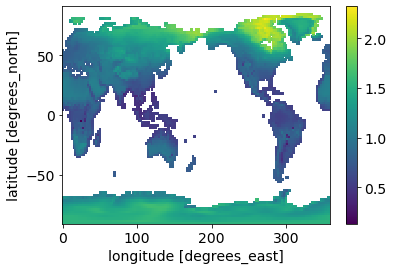

In [72]:
(delta_T.where(landweights>0)*CO2x2_warming_factor_1degreeglobal).plot()

# EOF of change
Normalize by subtract temperature change at each point from global mean change

In [176]:
var_array_delta = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)

In [177]:
globalmean_temp_ref=(ref_tseries*areaweights).sum(dim=['lat','lon']).mean(dim='year').values
ref_tseries_annual = ref_tseries.mean(dim='year')

In [178]:
for i, key in enumerate(var_array.ensemble_key):
    ds = var_array[:,:,i]
    globalmean_temp = ((ds*areaweights).sum(dim=['lat','lon']).values)
    globalmean_temp_delta = globalmean_temp-globalmean_temp_ref
    ds_delta = ds - ref_tseries_annaul
    var_array_delta[:,:,i]=ds_delta-globalmean_temp_delta

In [179]:
ds_eofs=var_array_delta

In [180]:
# Rearrange all-model dataset for EOF
ds_eofs=ds_eofs.transpose()
ds_eofs=ds_eofs.rename({"ensemble_key": "time"})
ds_eofs['time']=np.arange('2000-01-01', '2000-02-06', dtype='datetime64') #11
ds_eofs=ds_eofs-ds_eofs.mean(dim='time')

In [181]:
solver = Eof(ds_eofs, weights=areaweights.transpose())
eofs = solver.eofs()
eofs = eofs.transpose()
pcs = solver.pcs()

## Make figures

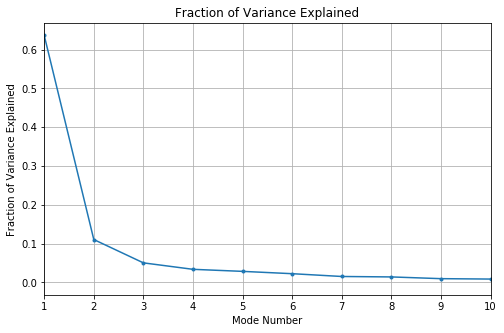

In [182]:
fig = plt.figure(figsize=(8,5))
plt.plot(np.arange(1,np.size(ds_eofs['time'])+1),solver.varianceFraction().values,'.-')
solver.varianceFraction().values[0]+solver.varianceFraction().values[1]
plt.xlim([1,10])
plt.title('Fraction of Variance Explained')
plt.xlabel('Mode Number')
plt.ylabel('Fraction of Variance Explained')
plt.grid()
plt.savefig(var+'_frac_variance_explained.png')

In [183]:
for i in np.arange(0,4):
    print('EOF '+str(i+1))
    print(solver.varianceFraction().values[i])
    print(solver.varianceFraction().values[0:i])

EOF 1
0.6365110076621779
EOF 2
0.11052123000891595
EOF 3
0.050436572749108656
EOF 4
0.03380490549290501


/glade/u/home/czarakas/coupled_PPE/code/analyze_simulations/quick_map.py:71: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  cbar.set_clim(clim)


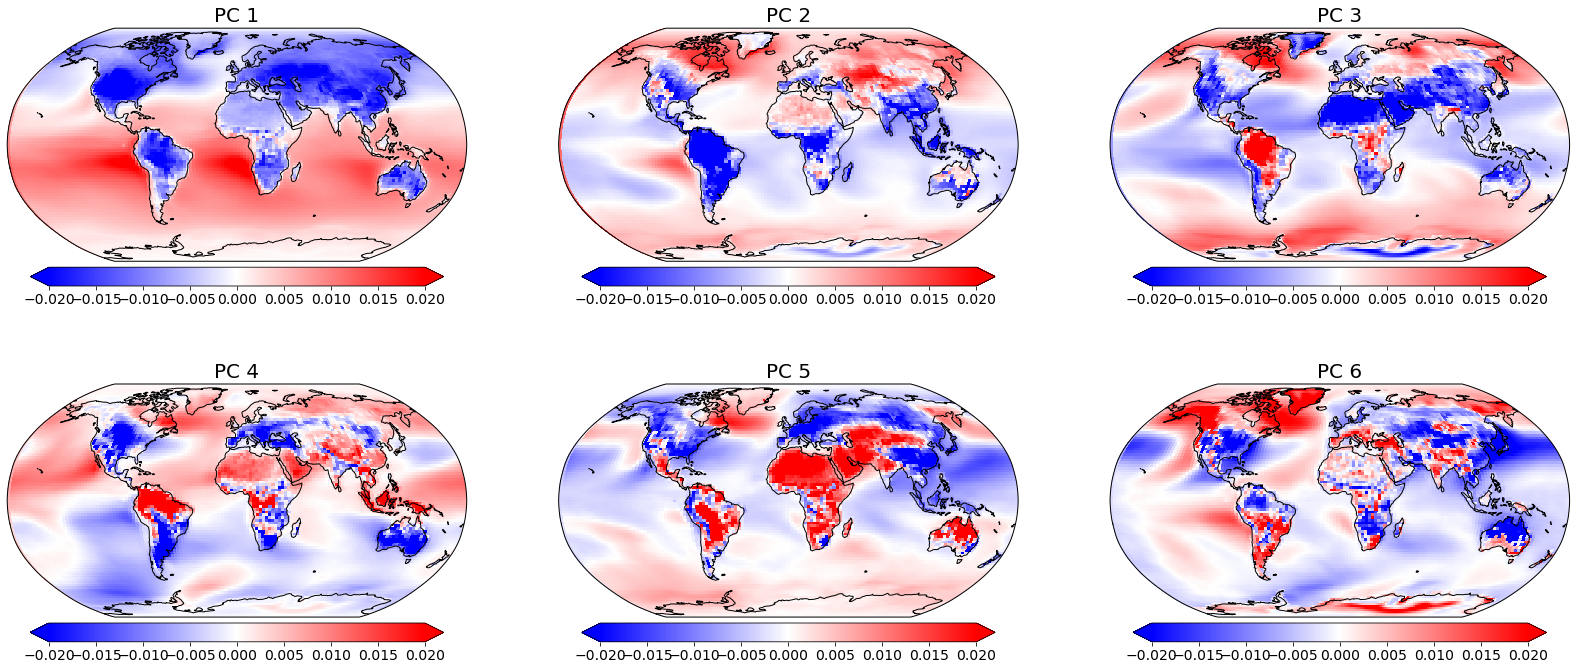

In [184]:
lats = eofs['lat'].values
lons = eofs['lon'].values
fig = plt.figure(figsize=(28, 12))
for i in range(0,6):
    quick_map.quick_map_subplot(eofs[:,:,i].values,lats,lons, nrow=2, ncol=3, ind=i,
                                clim=[-0.02,0.02],cmap=plt.cm.bwr,
                                title='PC '+str(i+1))
plt.savefig(var+'_PCs.png')

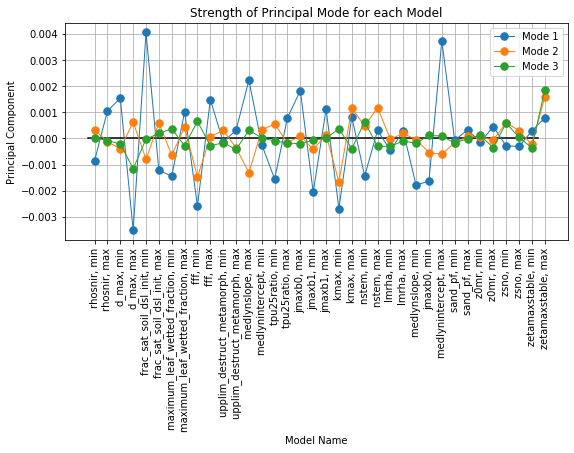

In [185]:
labels=descriptions#var_array.ensemble_key.values
fig = plt.figure(figsize=(9, 4))
plt.plot([0.5,np.size(labels)-0.5],[0,0],'-k')
for i in range(0,3):
    pcs_annual = pcs[:,i]
    plt.plot(np.arange(1,np.size(pcs_annual['time'])+1),
             pcs_annual,label='Mode '+str(i+1),linewidth=1,marker='.',markersize=15)
    plt.xlabel('Model Name')
    plt.ylabel('Principal Component')
    plt.title('Strength of Principal Mode for each Model')
plt.legend()
#plt.xlim([0.5,np.size(labels)-0.5])
plt.xticks(np.arange(1,np.size(labels)+0.5,1),labels=labels, rotation=90)
plt.grid()
plt.savefig(var+'_strength_principal_mode_per_sim.png')

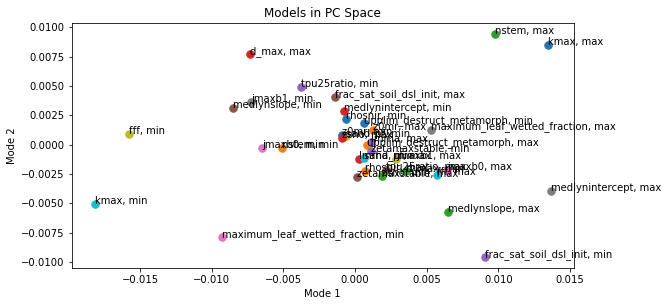

In [61]:
fig = plt.figure(figsize=(9, 4.5))
#plt.plot([-500,170],[0,0],'-k')
#plt.plot([0,0],[-175,150],'-k')
pc1 = pcs[:,0].values
pc2 = pcs[:,1].values
for m, modelname in enumerate(labels):
    if modelname=='CESM2':
        plt.plot(pc1[m], pc2[m],'.k',linewidth=0,markersize=15, label=modelname)
    else:
        plt.plot(pc1[m], pc2[m],marker='.',linewidth=0,markersize=15, label=modelname)
    plt.annotate(modelname, [pc1[m], pc2[m]])
plt.xlabel('Mode 1')
plt.ylabel('Mode 2')
plt.title('Models in PC Space')
#plt.legend(fontsize=12)
#plt.xlim([-100,150])
#plt.ylim([-20,70])
plt.savefig(var+'_PC1vsPC2_projection.png')